# Preparing the NoteBook

In [1]:
%load_ext autoreload
%autoreload 2

In [33]:
import sys, os, shutil
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import pandas as pd
import MDAnalysis as MDAnalysis
import MDAnalysis.analysis.hbonds.hbond_analysis
import mdtraj as md
import pytraj as pt
import nglview as nv
import seaborn as sns
#sns.set()

In [3]:
# Matplotlib options
%matplotlib inline
matplotlib.style.use('ggplot')
pylab.rcParams['figure.figsize'] = 12, 8

# DHFR files

In [4]:
dir_system="/DATA/projects/Learning_Python/MD_Analysis_examples/dhfr-solv/"

In [5]:
filename_traj="traj_comp.xtc"
filename_coors="dhfr_23558.gro"
filename_top="dhfr_23558.top"

In [6]:
file_traj=dir_system+filename_traj
file_coors=dir_system+filename_coors
file_top=dir_system+filename_top

# DHFR Visualization (structure and trajectory)

In [ ]:
md_coors = md.load(file_coors)
md_coors.remove_solvent()
view = nv.show_mdtraj(md_coors)
view

In [ ]:
md_traj = md.load(file_traj, top=file_coors)
md_traj.remove_solvent()
md_traj.center_coordinates()
traj_view = nv.show_mdtraj(md_traj)
traj_view

# Least RMSD with frame 0 as reference

Have a look to: https://towardsdatascience.com/tensorflow-rmsd-using-tensorflow-for-things-it-was-not-designed-to-do-ada4c9aa0ea2
Dou you know what quaternions are?

In [ ]:
rmsds = md.rmsd(md_traj, md_traj, 0, precentered=True) # md_traj.center_coordinates() was executed before

In [ ]:
plt.plot(rmsds)
plt.xlabel("saved frame")
plt.ylabel("RMSD")
plt.show()

In [ ]:
del(md_traj)

# H bonds with water

In [7]:
u = MDAnalysis.Universe(file_coors,file_traj) 

In [8]:
print("Number of atoms:",len(u.atoms),"  Number of frames:", len(u.trajectory))

Number of atoms: 23558   Number of frames: 20001


In [9]:
print(u.residues.resnames)

['MET' 'ILE' 'SER' ..., 'WAT' 'WAT' 'WAT']


In [12]:
group_O_wats=u.select_atoms('name O and resname WAT')

for atom in group_O_wats.atoms:
    atom.name='OW'

In [30]:
h = MDAnalysis.analysis.hbonds.HydrogenBondAnalysis(u, 'protein', 'resname WAT', distance=3.0, angle=120.0, step=100, filter_first=True)
h.run()

HBonds frame 20000:   201/201 [100.0%]


In [31]:
h.generate_table()
hbonds_table=h.table
hbonds_timeseries=h.timeseries

num_hbonds_per_frame=[len(ii) for ii in hbonds_timeseries]

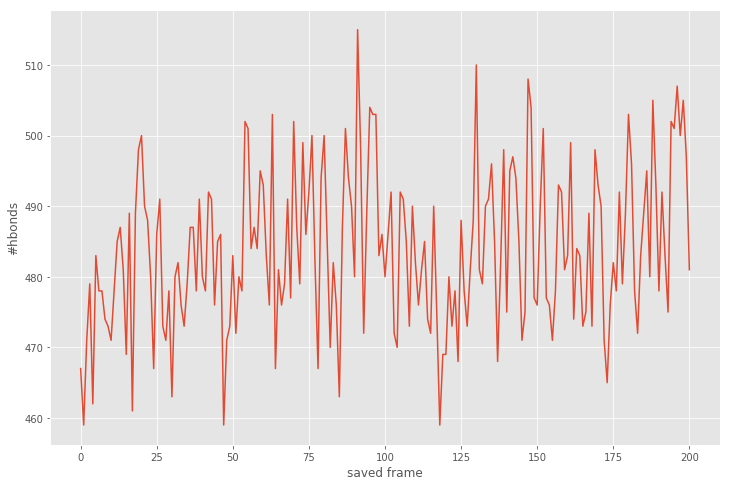

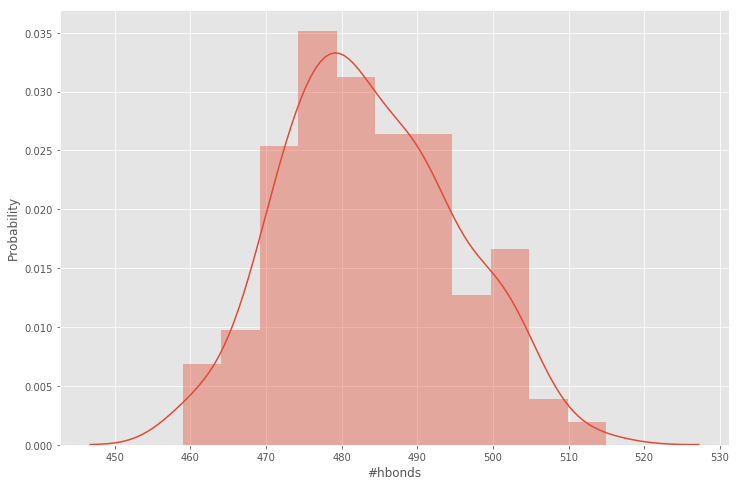

In [36]:
plt.plot(num_hbonds_per_frame)
plt.xlabel("saved frame")
plt.ylabel("#hbonds")
plt.title("Number of hbonds in time")
plt.show()

sns.distplot(num_hbonds_per_frame)
plt.xlabel("#hbonds")
plt.ylabel("Probability")
plt.title("Probability dist")
plt.show()

[467, 471, 500, 463, 480, 483, 493, 502, 500, 480, 480, 482, 469, 510, 475, 476, 483, 493, 503, 478, 481]


numpy.recarray